In [2]:
# Install missing packages
!pip install pandas matplotlib seaborn


Mounted at /content/drive


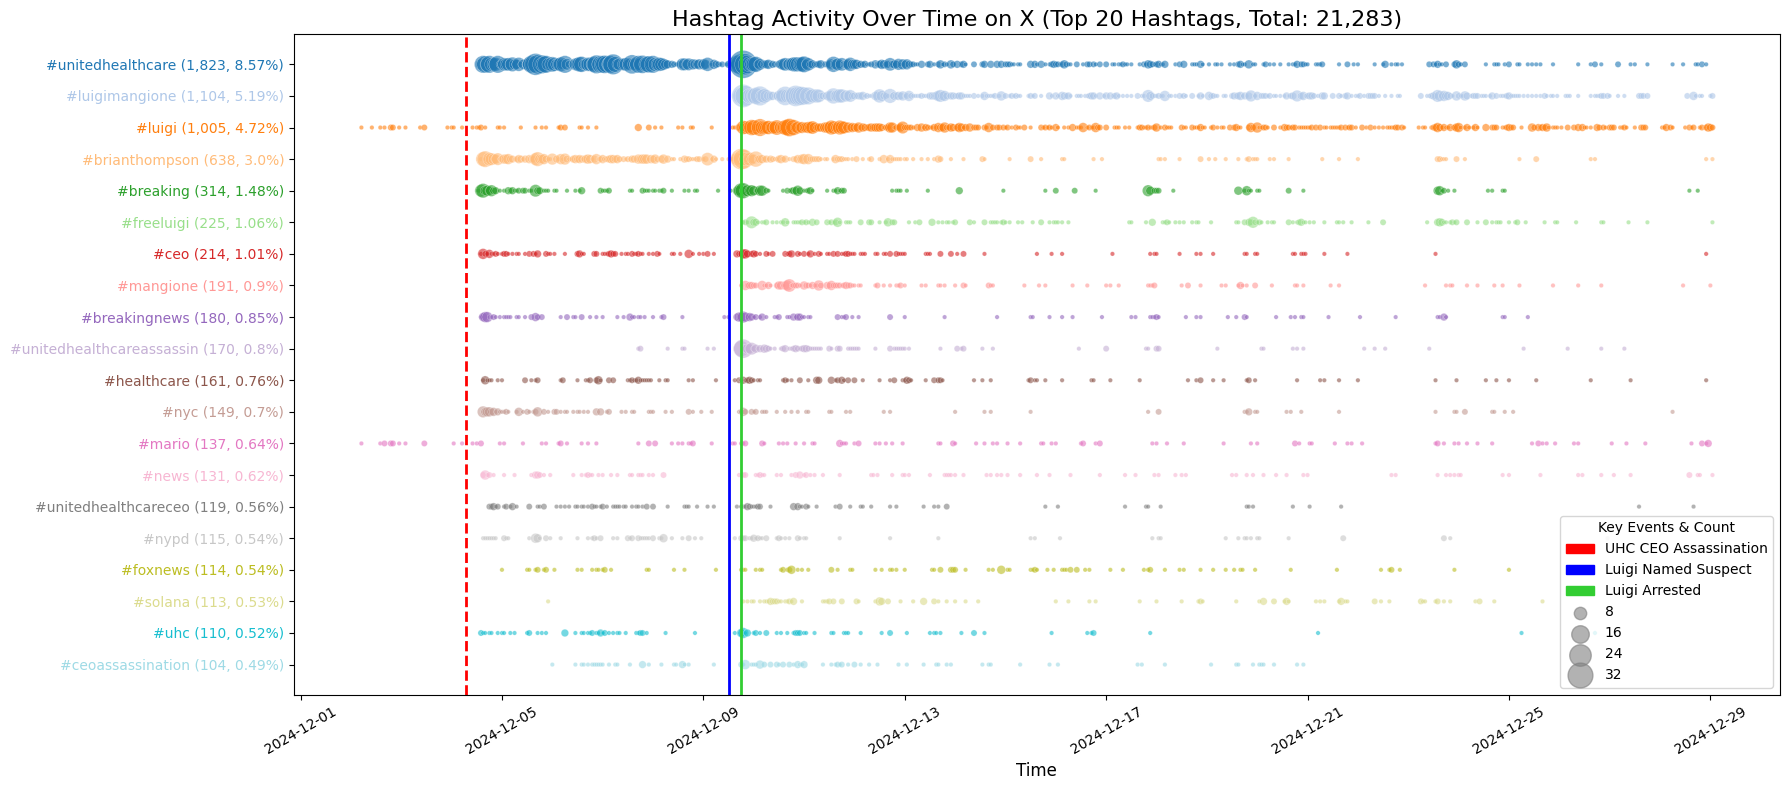

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.patches as mpatches # Import the patches module

# **Google Colab Path Handling**
from google.colab import drive # Import the drive module
from google.colab import files
drive.mount('/content/drive') # Mount Google Drive to access the dataset

# **Load dataset**
file_path = "/content/drive/MyDrive/_Mangione_Analysis/X data/cleaned_original_x_data.csv"
data = pd.read_csv(file_path)

# Convert 'DateTime' column to datetime format and extract Date & Hour
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')
data['Date'] = data['DateTime'].dt.date
data['Hour'] = data['DateTime'].dt.hour

# Extract hashtags from text and count total hashtags per row
def extract_hashtags(text):
    return [h.lower() for h in re.findall(r"(#[A-Za-z0-9_]+)", str(text))] if pd.notna(text) else []

data['hashtags'] = data['original_text'].apply(extract_hashtags)
data['Total_Hashtags'] = data['hashtags'].apply(len)  # New column for total hashtags per row

# Compute the total number of hashtags in the dataset
total_hashtags_count = data['Total_Hashtags'].sum()

# Remove rows with no hashtags
data = data[data['Total_Hashtags'] > 0]

# Unnest hashtags
hashtag_data = data.explode('hashtags')

# Get top 20 hashtags and their counts
hashtag_counts = hashtag_data['hashtags'].value_counts()
top_20_hashtags = hashtag_counts.head(20).index.tolist()
filtered_hashtags = hashtag_data[hashtag_data['hashtags'].isin(top_20_hashtags)]

# Calculate the percentage of the total for each hashtag
top_20_percentages = (hashtag_counts / total_hashtags_count * 100).round(2)

# Rename hashtags by appending count and percentage
hashtag_labels = {hashtag: f"{hashtag} ({hashtag_counts[hashtag]:,}, {top_20_percentages[hashtag]}%)"
    for hashtag in top_20_hashtags}

# Count occurrences per hour
hashtag_trends = filtered_hashtags.groupby(['Date', 'Hour', 'hashtags']).size().reset_index(name='Count')

# Convert Date & Hour to datetime
hashtag_trends['Datetime'] = pd.to_datetime(hashtag_trends['Date']) + pd.to_timedelta(hashtag_trends['Hour'], unit='h')

# Replace hashtags with new formatted versions
hashtag_trends['hashtags'] = hashtag_trends['hashtags'].replace(hashtag_labels)
top_20_formatted = [hashtag_labels[h] for h in top_20_hashtags]

# Ensure hashtags are categorized properly
hashtag_trends['hashtags'] = pd.Categorical(hashtag_trends['hashtags'], categories=top_20_formatted, ordered=True)

# Set color palette
color_palette = sns.color_palette("tab20", len(top_20_formatted))
color_mapping = {label: color_palette[i] for i, label in enumerate(top_20_formatted)}

# Define event timestamps
uhc_ceo_assassination_time = pd.to_datetime("2024-12-04 06:44:00")  # Precise time of the assassination
luigi_named_suspect_time = pd.to_datetime("2024-12-09 12:00:00")  # Time Luigi was publicly named
luigi_arrest_time = pd.to_datetime("2024-12-09 18:00:00")  # Time of Luigi's arrest

# Create plot
fig, ax = plt.subplots(figsize=(18, 8))  # Keep graph size normal

# Bubble Chart - Hashtag Volume Over Time
sns.scatterplot(
    data=hashtag_trends, x='Datetime', y='hashtags', size='Count', hue='hashtags',
    palette=color_mapping, sizes=(10, 400), alpha=0.6, ax=ax, legend=False
)
ax.set_title(f"Hashtag Activity Over Time on X (Top 20 Hashtags, Total: {total_hashtags_count:,})", fontsize=16)  # Add total to title
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("")  # Removed the word 'Hashtags'
ax.tick_params(axis='x', rotation=30)

# Restore Hashtag Colors
for label in ax.get_yticklabels():
    hashtag_text = label.get_text()
    if hashtag_text in color_mapping:
        label.set_color(color_mapping[hashtag_text])  # Set font color to match circles

# Add Event Markers (Vertical Lines)
ax.axvline(x=uhc_ceo_assassination_time, color='red', linestyle='--', linewidth=2)  # Red for assassination
ax.axvline(x=luigi_named_suspect_time, color='blue', linestyle='-', linewidth=2)  # Blue for suspect named
ax.axvline(x=luigi_arrest_time, color='limegreen', linestyle='-', linewidth=2)  # Bright Green for arrest

# Create Legend
event_patches = [
    mpatches.Patch(color="red", label="UHC CEO Assassination"),
    mpatches.Patch(color="blue", label="Luigi Named Suspect"),
    mpatches.Patch(color="limegreen", label="Luigi Arrested")
]
# Circle sizes in Legend
size_values = [8, 16, 24, 32]
size_scaling = [plt.scatter([], [], s=(v * 10), color='gray', alpha=0.6) for v in size_values]

# Combine Both Legends into One
combined_legend = ax.legend(
    handles=event_patches + size_scaling,
    labels=["UHC CEO Assassination", "Luigi Named Suspect", "Luigi Arrested"] + [str(v) for v in size_values],
    title="Key Events & Count",
    loc="lower right", fontsize=10
)

#plot graph
plt.tight_layout()
plt.show()
